In [ ]:
!pip install openai
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 44 kB 2.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 163 kB 13.8 MB/s 
  Created wheel for openai: filename=openai-0.25.0-py3-none-any.whl size=55880 sha256=d4336ea25a26f1fae15456e33789d164ef4c24a3bde086ddf3240b851da3ecac
  Stored in directory: /root/.cache/pip/wheels/19/de/db/e82770b480ec30fd4a6d67108744b9c52be167c04fcf4af7b5
Successfully built openai


In [ ]:
import openai
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import time
import re
import pandas as pd
import json

In [ ]:
# read and set gpt-3 api key
with open('gpt-3_api_key.txt', 'r') as fID:
  api_key = fID.readline()
openai.api_key = api_key

In [ ]:
# function that takes a prompt and returns the completed sentence
def get_gpt3_response_text(prompt, engine='text-davinci-002'):
  response = openai.Completion.create(
      engine=engine,
      prompt=prompt,
      temperature=0.7,
      max_tokens=256,
      top_p=1.0,
      frequency_penalty=0.0,
      presence_penalty=0.0)
  if response is None or len(response) == 0:
    return 'error', ''
  return response['choices'][0]['finish_reason'], response['choices'][0]['text']

In [ ]:
# utility functions 
# read jsonl files
def read_jsonl(path: str):
    with open(path) as fh:
        return [json.loads(line) for line in fh.readlines() if line]

# extract the answer from completed sentence
ANS_RE = re.compile(r"#### (\-?[0-9\.\,]+)")
INVALID_ANS = "[invalid]"

def extract_answer(completion):
    match = ANS_RE.search(completion)
    if match:
        match_str = match.group(1).strip()
        match_str = match_str.replace(",", "")
        return match_str
    else:
        return INVALID_ANS

def format_prompt(question, keywords=False):
  if keywords:
    return 'Q: ' + question + '\n\nA: Let\'s think step by step.'
  else:
    return 'Q: ' + question + '\n\nA:'

def get_qa_by_idx(idx, data):
  return data[idx]['question'], data[idx]['answer']

# Sentence BERT for question clustering

In [ ]:
# from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-mpnet-base-v2')#, device='cuda')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

### Encode all questions from the training dataset and store the embeddings

In [ ]:
train_q = [x['question'] for x in read_jsonl('train.jsonl')]
train_q_embeddings = model.encode(train_q)

In [ ]:
# np.save('train_q_embeddings', train_q_embeddings)
train_q_embeddings = np.load('train_q_embeddings.npy')

100%|██████████| 8/8 [00:38<00:00,  4.76s/it]


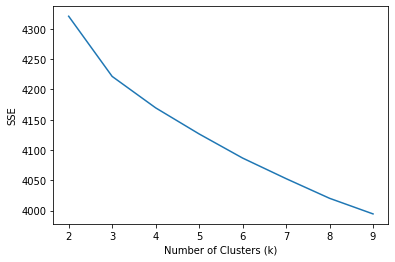

In [ ]:
sse = {}

for k in tqdm(range(2, 10)):
  kmeans = KMeans(n_clusters=k, max_iter=1000).fit(train_q_embeddings)
  sse[k] = kmeans.inertia_

fig, ax = plt.subplots()
ax.plot(list(sse.keys()), list(sse.values()))
ax.set_xlabel('Number of Clusters (k)')
ax.set_ylabel('SSE')
plt.show()

In [ ]:
K = 3

kmeans = KMeans(n_clusters=K, max_iter=1000).fit(train_q_embeddings)

In [ ]:
cluster_centers = kmeans.cluster_centers_

NameError: ignored

In [ ]:
K = 3

# np.save('train_q_cluster_centers', cluster_centers)
cluster_centers = np.load('train_q_cluster_centers.npy')

In [ ]:
def get_nearest_embeddings_idx(e, embeddings):
  dist_to_embeddings = np.linalg.norm(embeddings - e, axis=1).reshape(-1,1)
  nearest_embeddings_idx = np.argmin(dist_to_embeddings, axis=0)[0]
  return nearest_embeddings_idx

In [ ]:
most_repr_indices = {}
for c in range(K):
  most_repr_indices[c] = get_nearest_embeddings_idx(cluster_centers[c, :], train_q_embeddings)
  
most_repr_indices

{0: 6260, 1: 2432, 2: 2232}

In [ ]:
def get_embedding_most_repr_label(embedding):
  cluster_idx = get_nearest_embeddings_idx(embedding, cluster_centers)
  return cluster_idx

def get_embedding_nearest_idx(embedding):
  return get_nearest_embeddings_idx(embedding, train_q_embeddings)

In [ ]:
train_data = read_jsonl('train.jsonl')
test_data = read_jsonl('test.jsonl')

In [ ]:
N = 100

random.seed(42)
test_ind = list(range(len(test_data)))
random.shuffle(test_ind)

test_qa = [get_qa_by_idx(idx, test_data) for idx in test_ind[:N]]

In [ ]:
test_q = [qa[0] for qa in test_qa]
test_a = [qa[1] for qa in test_qa]
test_numeric_a = [float(extract_answer(a)) for a in test_a]

In [ ]:
train_q = [qa['question'] for qa in train_data]
train_a = [qa['answer'] for qa in train_data]

In [ ]:
test_q_embeddings = model.encode(test_q)
test_q_embeddings.shape

(100, 768)

In [ ]:
def extract_completion_answer(completion):
  tmp_list = []
  all_match = re.findall('[0-9.,]+', completion)
  for m in all_match:
    if m == '.':
      continue
    if m == ',':
      continue
    m = re.sub(',', '', m)
    try:
      tmp_list.append(float(m))
    except ValueError:
      continue
  if len(tmp_list) == 0:
    return None
  return tmp_list[-1]

# 0-shot

In [ ]:
zero_shot_prompt = []
zero_shot_msg = []
zero_shot_completion = []

for q in tqdm(test_q):
  time.sleep(1)
  prompt = format_prompt(q, keywords=False)
  msg, completion = get_gpt3_response_text(prompt)
  zero_shot_prompt.append(prompt)
  zero_shot_msg.append(msg)
  zero_shot_completion.append(completion)

100%|██████████| 100/100 [03:46<00:00,  2.26s/it]


In [ ]:
zero_shot_df = pd.DataFrame({
    'prompt_method': '0-shot', 
    'prompt': zero_shot_prompt, 
    'msg': zero_shot_msg, 
    'completion': zero_shot_completion, 
    'completion_answer': [extract_completion_answer(c) for c in zero_shot_completion],
    'true_answer': test_numeric_a})

zero_shot_df

,prompt_method,prompt,msg,completion,completion_answer,true_answer
0,0-shot,Q: Jared is trying to increase his typing spee...,stop,The average of the three measurements will be...,50.0,52.0
1,0-shot,Q: Jordan has 2 children who wear diapers. Ea...,stop,Jordan changes 2.5 diapers per day.,2.5,5.0
2,0-shot,Q: A wooden bridge can carry no more than 5000...,stop,The maximum number of boxes that can be loade...,333.0,83.0
3,0-shot,Q: Tim has a box with 7 blue shoe boxes and 9 ...,stop,4 red shoeboxes and 4 blue shoeboxes,4.0,10.0
4,0-shot,Q: Dominick went to his team's changing room a...,stop,Dominick saw 60 items.,60.0,70.0
...,...,...,...,...,...,...
95,0-shot,"Q: To heat during the winter, Ali ordered 850 ...",stop,"$15,300",15300.0,306.0
96,0-shot,Q: Sam sells bread. He has a target of selling...,stop,Sam was off from his target by 7 crates.,7.0,55.0
97,0-shot,Q: One meatball sub sandwich contains 4 meatba...,stop,There were 22 meatballs in the sub sandwiches...,22.0,24.0
98,0-shot,Q: Damien created a currency based on bottle c...,stop,Damien would make $75 in a 30 day month.,30.0,75.0


# 0-shot with key words: "Let's think step by step."

In [ ]:
zero_shot_keywords_prompt = []
zero_shot_keywords_msg = []
zero_shot_keywords_completion = []

for q in tqdm(test_q):
  time.sleep(1)
  prompt = format_prompt(q, keywords=True)
  msg, completion = get_gpt3_response_text(prompt)
  zero_shot_keywords_prompt.append(prompt)
  zero_shot_keywords_msg.append(msg)
  zero_shot_keywords_completion.append(completion)

100%|██████████| 100/100 [09:59<00:00,  5.99s/it]


In [ ]:
zero_shot_keywords_df = pd.DataFrame({
    'prompt_method': '0-shot with keywords', 
    'prompt': zero_shot_keywords_prompt, 
    'msg': zero_shot_keywords_msg, 
    'completion': zero_shot_keywords_completion, 
    'completion_answer': [extract_completion_answer(c) for c in zero_shot_keywords_completion],
    'true_answer': test_numeric_a})

zero_shot_keywords_df

,prompt_method,prompt,msg,completion,completion_answer,true_answer
0,0-shot with keywords,Q: Jared is trying to increase his typing spee...,stop,"\n\nFirst, Jared starts with 47 words per min...",52.0,52.0
1,0-shot with keywords,Q: Jordan has 2 children who wear diapers. Ea...,stop,\n\nThere are 2 children.\nEach child requires...,5.0,5.0
2,0-shot with keywords,Q: A wooden bridge can carry no more than 5000...,stop,\n\n1) The truck can carry no more than 5000 -...,163.0,83.0
3,0-shot with keywords,Q: Tim has a box with 7 blue shoe boxes and 9 ...,stop,"\n\nFirst, we'll use 3 blue shoeboxes. This l...",6.0,10.0
4,0-shot with keywords,Q: Dominick went to his team's changing room a...,stop,"\n\nThere are half as many robots as helmets, ...",40.0,70.0
...,...,...,...,...,...,...
95,0-shot with keywords,"Q: To heat during the winter, Ali ordered 850 ...",stop,"First, we need to figure out how many 50 kg b...",306.0,306.0
96,0-shot with keywords,Q: Sam sells bread. He has a target of selling...,stop,"\n\nOn Monday and Friday, Sam was closed, so ...",55.0,55.0
97,0-shot with keywords,Q: One meatball sub sandwich contains 4 meatba...,stop,\n\nSidney ordered 3 less than 10 meatball su...,12.0,24.0
98,0-shot with keywords,Q: Damien created a currency based on bottle c...,stop,"\n\nFirst, we need to calculate how many bott...",30.0,75.0


# Auto-COT Most representative question

In [ ]:
repr_auto_cot = {}

for key, value in tqdm(most_repr_indices.items()):
  q = get_qa_by_idx(value, train_data)[0]
  prompt = format_prompt(q, keywords=True)
  msg, completion = get_gpt3_response_text(prompt)
  if msg == 'stop':
    repr_auto_cot[key] = prompt + completion + '\n\n'

100%|██████████| 3/3 [00:16<00:00,  5.35s/it]


In [ ]:
auto_cot_repr_prompt = []
auto_cot_repr_msg = []
auto_cot_repr_completion = []

for q, e in tqdm(zip(test_q, test_q_embeddings)):
  time.sleep(1)
  label = get_embedding_most_repr_label(e)
  prompt = repr_auto_cot[label] + format_prompt(q, keywords=True)
  msg, completion = get_gpt3_response_text(prompt)
  auto_cot_repr_prompt.append(prompt)
  auto_cot_repr_msg.append(msg)
  auto_cot_repr_completion.append(completion)

100it [09:00,  5.40s/it]


In [ ]:
auto_cot_repr_df = pd.DataFrame({
    'prompt_method': 'Auto-COT representative question', 
    'prompt': auto_cot_repr_prompt, 
    'msg': auto_cot_repr_msg, 
    'completion': auto_cot_repr_completion, 
    'completion_answer': [extract_completion_answer(c) for c in auto_cot_repr_completion],
    'true_answer': test_numeric_a})

auto_cot_repr_df

,prompt_method,prompt,msg,completion,completion_answer,true_answer
0,Auto-COT representative question,Q: Adam goes to school every day. On Monday he...,stop,\n\nJared's first typing speed is 47 WPM. \n\...,52.0,52.0
1,Auto-COT representative question,Q: Adam goes to school every day. On Monday he...,stop,\n\nJordan has 2 children who wear diapers. T...,5.0,5.0
2,Auto-COT representative question,Q: Annie brought 20 brownies to school. She g...,stop,\n\nThe weight limit of the bridge is 5000 pou...,334.0,83.0
3,Auto-COT representative question,Q: Annie brought 20 brownies to school. She g...,stop,\n\nTim has a box with 7 blue shoe boxes and ...,6.0,10.0
4,Auto-COT representative question,Q: Annie brought 20 brownies to school. She g...,stop,\n\nDominick went to his team's changing room...,80.0,70.0
...,...,...,...,...,...,...
95,Auto-COT representative question,Q: Sandra wants to buy some sweets. She saved ...,stop,\nAli ordered 850 kilos of coal. \nEach bag o...,306.0,306.0
96,Auto-COT representative question,Q: Sandra wants to buy some sweets. She saved ...,stop,\nThe target is 120 crates. \nHe was closed o...,55.0,55.0
97,Auto-COT representative question,Q: Annie brought 20 brownies to school. She g...,stop,\n\nOne meatball sub sandwich contains 4 meat...,3.0,24.0
98,Auto-COT representative question,Q: Sandra wants to buy some sweets. She saved ...,stop,\nWe're looking for how much money he makes i...,75.0,75.0


# Auto-COT Nearest question

In [ ]:
auto_cot_nearest_prompt = []
auto_cot_nearest_msg = []
auto_cot_nearest_completion = []

for q, e in tqdm(zip(test_q, test_q_embeddings)):
  time.sleep(1)
  idx = get_embedding_nearest_idx(e)
  prompt_train = format_prompt(train_q[idx], keywords=True)
  msg_train, completion_train = get_gpt3_response_text(prompt_train)
  prompt = prompt_train + completion_train + '\n\n'+ format_prompt(q, keywords=True)
  time.sleep(1)
  msg, completion = get_gpt3_response_text(prompt)
  auto_cot_nearest_prompt.append(prompt)
  auto_cot_nearest_msg.append(msg)
  auto_cot_nearest_completion.append(completion)

100it [19:24, 11.65s/it]


In [ ]:
auto_cot_nearest_df = pd.DataFrame({
    'prompt_method': 'Auto-COT nearest question', 
    'prompt': auto_cot_nearest_prompt, 
    'msg': auto_cot_nearest_msg, 
    'completion': auto_cot_nearest_completion, 
    'completion_answer': [extract_completion_answer(c) for c in auto_cot_nearest_completion],
    'true_answer': test_numeric_a})

auto_cot_nearest_df

,prompt_method,prompt,msg,completion,completion_answer,true_answer
0,Auto-COT nearest question,Q: The company's data entry team had 5 employe...,stop,"To find the average, we must first add up al...",52.0,52.0
1,Auto-COT nearest question,Q: There are 180 school days in the academic y...,stop,\n\nEach child requires 5 diaper changes per ...,5.0,5.0
2,Auto-COT nearest question,Q: Donna is trying to figure out if her truck ...,stop,\n\nThe combined weight of the driver and the...,333.0,83.0
3,Auto-COT nearest question,Q: Mary has 26 blue shirts and 36 brown shirts...,stop,\n\nIf he uses 3 blue shoeboxes and 1/3 red o...,6.0,10.0
4,Auto-COT nearest question,"Q: To keep himself busy in class, Michael make...",stop,\n\nStep 1: We need to know how many footballs...,35.0,70.0
...,...,...,...,...,...,...
95,Auto-COT nearest question,"Q: Mustafa buys a fridge, a TV and a computer ...",stop,"We know that Ali ordered 850 kilos of coal, a...",18.0,306.0
96,Auto-COT nearest question,Q: On Thursday the Meat Market sold 210kg of g...,stop,\n\nOne week he was closed on Monday and Frid...,35.0,55.0
97,Auto-COT nearest question,Q: Antonio is preparing a meal of spaghetti an...,stop,\n\nSidney ordered 3 less than 10 meatball sa...,12.0,24.0
98,Auto-COT nearest question,Q: Jon runs a website where he gets paid for e...,stop,"In one day, he finds 10 bottle caps and each...",75.0,75.0


# Manual-COT Most representative question

In [ ]:
manual_cot_repr_prompt = []
manual_cot_repr_msg = []
manual_cot_repr_completion = []

most_repr_indices
acc = 0
for q, e in tqdm(zip(test_q, test_q_embeddings)):
  time.sleep(1)
  label = get_embedding_most_repr_label(e)
  idx = most_repr_indices[label]
  prompt = format_prompt(train_q[idx], keywords=False) + ' ' + train_a[idx] + '\n\n' + format_prompt(q, keywords=False)
  print(prompt)
  acc += 1
  if acc == 10:
    break
  # msg, completion = get_gpt3_response_text(prompt)
  # manual_cot_repr_prompt.append(prompt)
  # manual_cot_repr_msg.append(msg)
  # manual_cot_repr_completion.append(completion)

In [ ]:
manual_cot_repr_df = pd.DataFrame({
    'prompt_method': 'Manual-COT representative question', 
    'prompt': manual_cot_repr_prompt, 
    'msg': manual_cot_repr_msg, 
    'completion': manual_cot_repr_completion, 
    'completion_answer': [extract_completion_answer(c) for c in manual_cot_repr_completion],
    'true_answer': test_numeric_a})

manual_cot_repr_df

,prompt_method,prompt,msg,completion,completion_answer,true_answer
0,Manual-COT representative question,Q: Adam goes to school every day. On Monday he...,stop,"The first measurement is 47 WPM, the second i...",52.0,52.0
1,Manual-COT representative question,Q: Adam goes to school every day. On Monday he...,stop,Jordan changes <<2.5>>2.5 diapers per day.,2.5,5.0
2,Manual-COT representative question,Q: Annie brought 20 brownies to school. She g...,stop,"The truck, including the driver and the empty...",83.0,83.0
3,Manual-COT representative question,Q: Annie brought 20 brownies to school. She g...,stop,Tim has a total of 7+9=<<7+9=16>>16 shoeboxes...,7.0,10.0
4,Manual-COT representative question,Q: Annie brought 20 brownies to school. She g...,stop,There are 20 helmets and 40 robots.,40.0,70.0
...,...,...,...,...,...,...
95,Manual-COT representative question,Q: Sandra wants to buy some sweets. She saved ...,stop,Ali ordered 850 kilos of coal. There are 50 k...,306.0,306.0
96,Manual-COT representative question,Q: Sandra wants to buy some sweets. She saved ...,stop,Sam was off from his target by 5 crates.,5.0,55.0
97,Manual-COT representative question,Q: Annie brought 20 brownies to school. She g...,stop,The total number of meatballs in the sandwich...,16.0,24.0
98,Manual-COT representative question,Q: Sandra wants to buy some sweets. She saved ...,stop,"Damien would make $2.50 a day, so in a 30 day...",75.0,75.0


# Manual-COT Nearest question

In [ ]:
manual_cot_nearest_prompt = []
manual_cot_nearest_msg = []
manual_cot_nearest_completion = []

for q, e in tqdm(zip(test_q, test_q_embeddings)):
  idx = get_embedding_nearest_idx(e)
  prompt_train = format_prompt(train_q[idx], keywords=False)
  completion_train = train_a[idx]
  prompt = prompt_train + ' ' + completion_train + '\n\n'+ format_prompt(q, keywords=False)
  time.sleep(1)
  msg, completion = get_gpt3_response_text(prompt)
  manual_cot_nearest_prompt.append(prompt)
  manual_cot_nearest_msg.append(msg)
  manual_cot_nearest_completion.append(completion)

100it [06:50,  4.10s/it]


In [ ]:
manual_cot_nearest_df = pd.DataFrame({
    'prompt_method': 'Manual-COT nearest question', 
    'prompt': manual_cot_nearest_prompt, 
    'msg': manual_cot_nearest_msg, 
    'completion': manual_cot_nearest_completion, 
    'completion_answer': [extract_completion_answer(c) for c in manual_cot_nearest_completion],
    'true_answer': test_numeric_a})

manual_cot_nearest_df

,prompt_method,prompt,msg,completion,completion_answer,true_answer
0,Manual-COT nearest question,Q: The company's data entry team had 5 employe...,stop,The average of the three measurements would be...,52.0,52.0
1,Manual-COT nearest question,Q: There are 180 school days in the academic y...,stop,\n\nJordan changes 5 diapers per day. His wife...,10.0,5.0
2,Manual-COT nearest question,Q: Donna is trying to figure out if her truck ...,stop,Since the truck's weight limit is 5000 pounds ...,96.0,83.0
3,Manual-COT nearest question,Q: Mary has 26 blue shirts and 36 brown shirts...,stop,Tim uses 7/3 = <<7/3=2.33>>2 blue shoeboxes.\...,6.0,10.0
4,Manual-COT nearest question,"Q: To keep himself busy in class, Michael make...",stop,Dominick saw 40 items.,40.0,70.0
...,...,...,...,...,...,...
95,Manual-COT nearest question,"Q: Mustafa buys a fridge, a TV and a computer ...",stop,850/50=17 bags of coal*18=$306,306.0,306.0
96,Manual-COT nearest question,Q: On Thursday the Meat Market sold 210kg of g...,stop,One week Sam sold 20 + 15 + 12 + 18 = <<20+15...,55.0,55.0
97,Manual-COT nearest question,Q: Antonio is preparing a meal of spaghetti an...,stop,10-3=7 sub sandwiches * 4 meatballs/sub sandwi...,40.0,24.0
98,Manual-COT nearest question,Q: Jon runs a website where he gets paid for e...,stop,10*$.25=$<<10*$.25=2.5>>2.5 per day\nSo he mak...,75.0,75.0


In [ ]:
zero_shot_df['question_idx'] = test_ind[:N]
zero_shot_keywords_df['question_idx'] = test_ind[:N]
auto_cot_repr_df['question_idx'] = test_ind[:N]
auto_cot_nearest_df['question_idx'] = test_ind[:N]
manual_cot_nearest_df['question_idx'] = test_ind[:N]
manual_cot_repr_df['question_idx'] = test_ind[:N]


zero_shot_df['question'] = test_q
zero_shot_keywords_df['question'] = test_q
auto_cot_repr_df['question'] = test_q
auto_cot_nearest_df['question'] = test_q
manual_cot_nearest_df['question'] = test_q
manual_cot_repr_df['question'] = test_q

result_df = pd.concat([zero_shot_df, zero_shot_keywords_df, auto_cot_repr_df, auto_cot_nearest_df, manual_cot_repr_df, manual_cot_nearest_df])

In [ ]:
result_df['correct'] = result_df['completion_answer'] == result_df['true_answer']
result_df['error'] = result_df['completion_answer'] - result_df['true_answer']
result_df['squared_error'] = (result_df['completion_answer'] - result_df['true_answer']) ** 2
result_df['absolute_error'] = abs(result_df['completion_answer'] - result_df['true_answer'])

In [ ]:
result_df.to_csv('result.csv', sep=';', index=False)
# result_df = pd.read_csv('result.csv', sep=';')

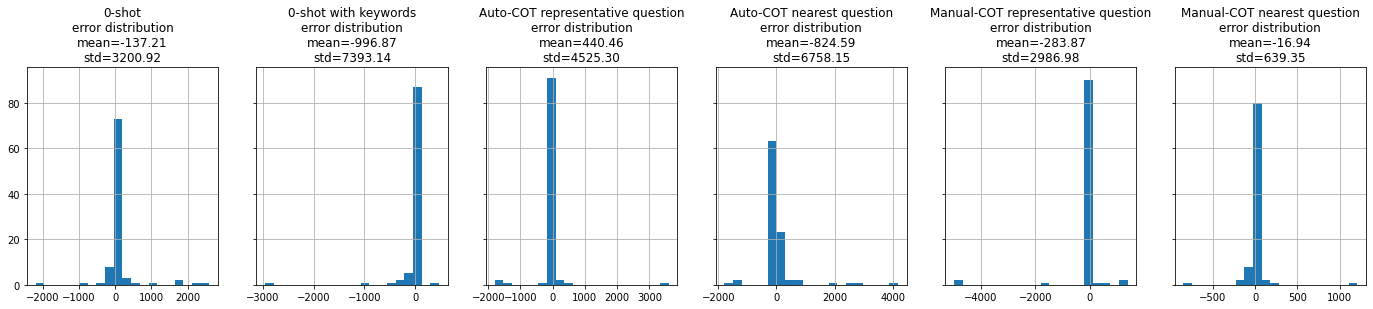

In [ ]:
fig, axes = plt.subplots(1, 6, figsize=(24, 4), sharey='row')

for prompt_method, ax in zip(['0-shot', '0-shot with keywords', 'Auto-COT representative question', 'Auto-COT nearest question', 'Manual-COT representative question', 'Manual-COT nearest question'], axes):
  df_tmp = result_df[result_df['prompt_method'] == prompt_method]
  error_std = df_tmp['error'].std()
  error_mean = df_tmp['error'].mean()
  df_tmp[(df_tmp['error'] > error_mean - 2 * error_std) & (df_tmp['error'] < error_mean + 2 * error_std)]['error'].hist(ax=ax, bins=20)
  ax.set_title(f'{prompt_method}\nerror distribution\nmean={error_mean:.2f}\nstd={error_std:.2f}')

In [ ]:
result_df.groupby(['prompt_method', 'correct'])['correct'].count()

prompt_method                       correct
0-shot                              False      87
                                    True       13
0-shot with keywords                False      56
                                    True       44
Auto-COT nearest question           False      69
                                    True       31
Auto-COT representative question    False      49
                                    True       51
Manual-COT nearest question         False      62
                                    True       38
Manual-COT representative question  False      64
                                    True       36
Name: correct, dtype: int64

In [ ]:
result_df.groupby(['prompt_method'])['squared_error'].mean()

prompt_method
0-shot                                1.015802e+07
0-shot with keywords                  5.510571e+07
Auto-COT nearest question             4.589123e+07
Auto-COT representative question      2.046758e+07
Manual-COT nearest question           4.049211e+05
Manual-COT representative question    8.912517e+06
Name: squared_error, dtype: float64

In [ ]:
result_df.groupby(['prompt_method'])['absolute_error'].mean()

prompt_method
0-shot                                 687.567708
0-shot with keywords                  1011.052176
Auto-COT nearest question             1112.409091
Auto-COT representative question       556.483100
Manual-COT nearest question            147.697980
Manual-COT representative question     529.528182
Name: absolute_error, dtype: float64